## Tree-Based Model for the Service Request dataset   
**Evaluated the performance of tree-based models on the dataset locally.**

In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor
import sys


#### Getting the CSV file from GCS.

In [3]:
!gsutil cp gs://nyc_servicerequest/processedInput/trainx1.csv data/demo1.csv

Copying gs://nyc_servicerequest/processedInput/trainx1.csv...
| [1 files][182.9 MiB/182.9 MiB]                                                
Operation completed over 1 objects/182.9 MiB.                                    


#### Getting started   
**Trying model on just a single file**

In [44]:
df = pd.read_csv('data/demo1.csv', header=None)

In [45]:
df.columns = ['index', 'day_period', 'day_of_week', \
             'zip_encode', 'location_encode', \
             'community_encode', 'agency_encode', \
             'complaint_encode', 'TimeTaken']


In [46]:
df.drop('index', axis=1, inplace=True)

In [47]:
df.head()

,day_period,day_of_week,zip_encode,location_encode,community_encode,agency_encode,complaint_encode,TimeTaken
0,evening,Mon-Tue,zip_bin4,location_bin1,community_bin2,agency_bin6,complaint_bin3,74.900
1,afternoon,Fri-Sat-Sun,zip_bin4,location_bin1,community_bin2,agency_bin6,complaint_bin3,498.759
2,morning,Mon-Tue,zip_bin4,location_bin4,community_bin2,agency_bin5,complaint_bin3,830.793
3,night,Wed-Thu,zip_bin4,location_bin4,community_bin2,agency_bin5,complaint_bin3,26.873
4,morning,Mon-Tue,zip_bin4,location_bin4,community_bin2,agency_bin5,complaint_bin3,40.107


In [48]:
one_hot_dp = pd.get_dummies(df['day_period'])
df = df.drop('day_period', axis=1)
df = df.join(one_hot_dp)

In [49]:
one_hot_week = pd.get_dummies(df['day_of_week'])
df = df.drop('day_of_week', axis=1)
df = df.join(one_hot_week)

In [50]:
from sklearn.preprocessing import LabelEncoder

In [51]:
df_new = df[['zip_encode', 'location_encode', 'community_encode', 'agency_encode',
       'complaint_encode']].apply(LabelEncoder().fit_transform)


In [52]:
df_old = df[['afternoon', 'evening', 'morning',
    'night', 'Fri-Sat-Sun', 'Mon-Tue', 'Wed-Thu','TimeTaken']]

In [53]:
ddf = pd.concat([df_new, df_old], axis=1)

In [54]:
ddf.columns

Index(['zip_encode', 'location_encode', 'community_encode', 'agency_encode',
       'complaint_encode', 'afternoon', 'evening', 'morning', 'night',
       'Fri-Sat-Sun', 'Mon-Tue', 'Wed-Thu', 'TimeTaken'],
      dtype='object')

In [55]:
X_cols = ['zip_encode', 'location_encode', 'community_encode', 'agency_encode',
       'complaint_encode', 'afternoon', 'evening', 'morning', 'night',
       'Fri-Sat-Sun', 'Mon-Tue', 'Wed-Thu']
y_col = 'TimeTaken'


**Splitting the dataset into Train and Test**

In [56]:
from sklearn.model_selection import train_test_split

In [57]:
X = ddf[X_cols]
y = ddf[y_col]

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)

In [59]:
from sklearn.tree import DecisionTreeRegressor

In [19]:
decision_tree = DecisionTreeRegressor()

In [20]:
decision_tree.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

In [18]:
from sklearn.metrics import mean_squared_error, r2_score

In [22]:
model_score = decision_tree.score(X_train, y_train)
print("coefficient of determination R^2 of the prediction.: ",model_score)

coefficient of determination R^2 of the prediction.:  0.11144848719894218


In [23]:
y_predicted = decision_tree.predict(X_test)

# The mean squared error
print("Mean squared error: %.2f"% mean_squared_error(y_test, y_predicted))
# Explained variance score: 1 is perfect prediction
print('Test Variance score: %.2f' % r2_score(y_test, y_predicted))


Mean squared error: 3033169.54
Test Variance score: 0.11


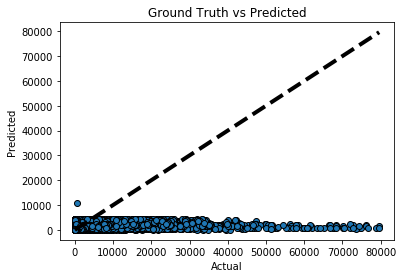

In [24]:
from sklearn.model_selection import cross_val_predict

fig, ax = plt.subplots()
ax.scatter(y_test, y_predicted, edgecolors=(0, 0, 0))
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
ax.set_title("Ground Truth vs Predicted")
plt.show()

### Time to remove the Outliers

In [60]:
ddf.shape

(1943254, 13)

In [61]:
print('1000 and above ',ddf[ddf['TimeTaken'] > 1000].shape[0]/ddf.shape[0])

1000 and above  0.06912117510114478


**Removing rows with TimeTaken > 1000 since they all are outliers, they only contribute 0.06% to the dataset**

**Now time to further analyze the dataset, check points with TimeTaken < 1000**

In [62]:
df = ddf[ddf['TimeTaken'] < 1000]

In [63]:
df.shape

(1808934, 13)

In [64]:
print('500 and above ',df[df['TimeTaken'] > 500].shape[0]/df.shape[0])

500 and above  0.06512785983347098


In [65]:
print('300 and above ',df[df['TimeTaken'] > 300].shape[0]/df.shape[0])

300 and above  0.14360335976879202


In [66]:
print('Below 200 ',df[df['TimeTaken'] < 200].shape[0]/df.shape[0])

Below 200  0.8026152419049009


**80% of the requests are resolved in 200 minutes or less. Those points are taken for the model. Let's check the model now.**

In [67]:
df = df[df['TimeTaken'] < 200]

In [69]:
df.reset_index(inplace=True)

In [27]:
from sklearn import linear_model
from sklearn import neighbors

In [28]:
from sklearn import svm

In [29]:
def error_anaylsis(y_pred, y_actual):
    # mean squared error
    m = len(y_actual)
    
    mse = np.sum((y_pred - y_actual)**2)

    # root mean squared error
    # m is the number of training examples
    rmse = np.sqrt(mse/m)
    
    # sum of square of residuals
    ssr = np.sum((y_pred - y_actual)**2)

    #  total sum of squares
    sst = np.sum((y_actual - np.mean(y_actual))**2)

    # R2 score
    r2_score = 1 - (ssr/sst)
    
    return mse, rmse, ssr, sst, r2_score

In [80]:
def generic_func_model_and_plot(ddf, X_cols, y_col, flag=True):
    models = ['Decision Tree', 'Ridge Regression', 'Bayesian Regression', 'RandomForest Regressor', 'AdaBoost Regressor',\
             'Gradient Boost Regression', 'XGBoost Regressor', 'LightGBM Regressor', 'CatBoost Regressor']
    rowind = ['RMSE (Train)', 'R2 Score (Train)', 'RMSE (Test)', 'R2 Score (Test)']
    
    if(flag):
        X = ddf[X_cols]
        y = ddf[y_col]
    else:
        X = ddf.iloc[:, :-1]
        y = ddf.iloc[:, -1]
        
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)
    
    arr = []
    
    #print('Decision Tree Regressor Results:')
    dec = DecisionTreeRegressor()
    dec.fit(X_train,y_train)
    y1_dec=dec.predict(X_train)
    y2_dec=dec.predict(X_test)

    one = []
    mse, rmse, ssr, sst, r2_score = error_anaylsis(y1_dec, y_train)
    one += [rmse, r2_score]
    
    mse, rmse, ssr, sst, r2_score = error_anaylsis(y2_dec, y_test)
    one += [rmse, r2_score]
    arr.append(one)
    
    
    
    #print('\nRidge Regression Results:')
    model = linear_model.Ridge()
    model.fit(X_train, y_train)
    y1_dec=model.predict(X_train)
    y2_dec=model.predict(X_test)

    two = []
    mse, rmse, ssr, sst, r2_score = error_anaylsis(y1_dec, y_train)
    two += [rmse, r2_score]

    mse, rmse, ssr, sst, r2_score = error_anaylsis(y2_dec, y_test)
    two += [rmse, r2_score]
    arr.append(two)

    
    """print('\nKNN Regressor Results:')
    n_neighbors=5
    knn=neighbors.KNeighborsRegressor(n_neighbors,weights='uniform')
    knn.fit(X_train,y_train)
    y1_dec=knn.predict(X_train)
    y2_dec=knn.predict(X_test)

    print('For train set')
    mse, rmse, ssr, sst, r2_score = error_anaylsis(y1_dec, y_train)
    print(mse, rmse, ssr, sst, r2_score)
    
    print('For test set')
    mse, rmse, ssr, sst, r2_score = error_anaylsis(y2_dec, y_test)
    print(mse, rmse, ssr, sst, r2_score)"""
    
    
    
    #print('\nBayesian Regressor Results:')
    reg = linear_model.BayesianRidge()
    reg.fit(X_train,y_train)
    y1_dec=reg.predict(X_train)
    y2_dec=reg.predict(X_test)

    three = []
    mse, rmse, ssr, sst, r2_score = error_anaylsis(y1_dec, y_train)
    three += [rmse, r2_score]
    
    mse, rmse, ssr, sst, r2_score = error_anaylsis(y2_dec, y_test)
    three += [rmse, r2_score]
    arr.append(three)
    
    
    
    #Random Forest
    rf = RandomForestRegressor()
    rf.fit(X_train, y_train)
    y1_dec=reg.predict(X_train)
    y2_dec=reg.predict(X_test)

    four = []
    mse, rmse, ssr, sst, r2_score = error_anaylsis(y1_dec, y_train)
    four += [rmse, r2_score]
    
    mse, rmse, ssr, sst, r2_score = error_anaylsis(y2_dec, y_test)
    four += [rmse, r2_score]
    arr.append(four)
    
    
    
    
    #AdaBoost 
    model = AdaBoostRegressor()
    model.fit(X_train, y_train)
    y1_dec=model.predict(X_train)
    y2_dec=model.predict(X_test)

    five = []
    mse, rmse, ssr, sst, r2_score = error_anaylsis(y1_dec, y_train)
    five += [rmse, r2_score]
    
    mse, rmse, ssr, sst, r2_score = error_anaylsis(y2_dec, y_test)
    five += [rmse, r2_score]
    arr.append(five)
    
    
    
    #GB
    model= GradientBoostingRegressor()
    model.fit(X_train, y_train)
    y1_dec=model.predict(X_train)
    y2_dec=model.predict(X_test)

    six = []
    mse, rmse, ssr, sst, r2_score = error_anaylsis(y1_dec, y_train)
    six += [rmse, r2_score]
    
    mse, rmse, ssr, sst, r2_score = error_anaylsis(y2_dec, y_test)
    six += [rmse, r2_score]
    arr.append(six)
    


    #XGBoost
    model=xgb.XGBRegressor()
    model.fit(X_train, y_train)
    y1_dec=model.predict(X_train)
    y2_dec=model.predict(X_test)

    seven = []
    mse, rmse, ssr, sst, r2_score = error_anaylsis(y1_dec, y_train)
    seven += [rmse, r2_score]
    
    mse, rmse, ssr, sst, r2_score = error_anaylsis(y2_dec, y_test)
    seven += [rmse, r2_score]
    arr.append(seven)
    

    
    
    #LightGBM
    train_data=lgb.Dataset(X_train,label=y_train,silent=True)
    params = {'learning_rate':0.001}
    model= lgb.train(params, train_data, verbose_eval=False)
    y1_dec=model.predict(X_train)
    y2_dec=model.predict(X_test)
    
    eight = []
    mse, rmse, ssr, sst, r2_score = error_anaylsis(y1_dec, y_train)
    eight += [rmse, r2_score]
    
    mse, rmse, ssr, sst, r2_score = error_anaylsis(y2_dec, y_test)
    eight += [rmse, r2_score]
    arr.append(eight)
    
    
    #CatBoost
    fsock=open("train_out.log",'w')
    sys_old_out_put=sys.stdout
    sys.stdout=fsock
    
    model=CatBoostRegressor()
    #categorical_features_indices = np.where(df.dtypes != np.float)[0]
    model.fit(X_train,y_train)
    y1_dec=model.predict(X_train)
    y2_dec=model.predict(X_test)
    
    sys.stdout=sys_old_out_put
    fsock.close()

    nine = []
    mse, rmse, ssr, sst, r2_score = error_anaylsis(y1_dec, y_train)
    nine += [rmse, r2_score]
    
    mse, rmse, ssr, sst, r2_score = error_anaylsis(y2_dec, y_test)
    nine += [rmse, r2_score]
    arr.append(nine)


    
    return pd.DataFrame(arr, columns=rowind, index=models)

In [55]:
generic_func_model_and_plot(df, X_cols, y_col)

,RMSE (Train),R2 Score (Train),RMSE (Test),R2 Score (Test)
Decision Tree,40.385639,0.465261,40.424635,0.464632
Ridge Regression,53.187294,0.072521,53.223093,0.071973
Bayesian Regression,53.187294,0.072521,53.223085,0.071973
RandomForest Regressor,53.187294,0.072521,53.223085,0.071973
AdaBoost Regressor,45.843450,0.310962,45.871042,0.310653
Gradient Boost Regression,41.176389,0.444115,41.168081,0.444759
XGBoost Regressor,41.176443,0.444114,41.168183,0.444756
LightGBM Regressor,52.906222,0.082298,52.926335,0.082293
CatBoost Regressor,40.436547,0.463912,40.423561,0.464660


As it can be seen, the Decision Tree perform the best.

In [70]:
df1 = df[df['TimeTaken'] < 125]

In [72]:
df1.reset_index(inplace=True)

In [32]:
generic_func_model_and_plot(df1, X_cols, y_col)

[15:05:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


,RMSE (Train),R2 Score (Train),RMSE (Test),R2 Score (Test)
Decision Tree,25.022257,0.529643,25.019044,0.530313
Ridge Regression,35.400598,0.058554,35.430204,0.058080
Bayesian Regression,35.400598,0.058554,35.430207,0.058080
RandomForest Regressor,35.400598,0.058554,35.430207,0.058080
AdaBoost Regressor,27.810688,0.418971,27.780213,0.420921
Gradient Boost Regression,25.467770,0.512745,25.421432,0.515084
XGBoost Regressor,25.467782,0.512745,25.421447,0.515083
LightGBM Regressor,34.752881,0.092690,34.772576,0.092722
CatBoost Regressor,25.058696,0.528273,25.019323,0.530303


Again even with the filter, the Decision Tree consistently perform well giving lowest RMSE for both train and Test datasets and High R2 score values.

### Trying PCA with the Dataset

In [73]:
from sklearn.decomposition import PCA
pca = PCA(n_components=6)
principalComponents = pca.fit_transform(df.iloc[:, :-1])

In [77]:
df_pca = pd.concat([pd.DataFrame(principalComponents), df['TimeTaken']], axis=1)
df_pca.columns = ['pca1', 'pca2', 'pca3', 'pca4', 'pca5', 'pca6', 'TimeTaken']

In [82]:
generic_func_model_and_plot(df_pca, X_cols, y_col, flag=False)

[15:33:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


,RMSE (Train),R2 Score (Train),RMSE (Test),R2 Score (Test)
Decision Tree,7.272918e-17,1.000000,49.717168,0.190208
Ridge Regression,5.218516e+01,0.107142,52.202167,0.107234
Bayesian Regression,5.218516e+01,0.107142,52.202166,0.107234
RandomForest Regressor,5.218516e+01,0.107142,52.202166,0.107234
AdaBoost Regressor,4.846987e+01,0.229750,48.507304,0.229141
Gradient Boost Regression,4.000846e+01,0.475202,40.013467,0.475467
XGBoost Regressor,4.003396e+01,0.474533,40.035917,0.474878
LightGBM Regressor,5.285690e+01,0.084008,52.875725,0.084047
CatBoost Regressor,3.914290e+01,0.497664,39.169960,0.497349


In [83]:
pca = PCA(n_components=6)
principalComponents = pca.fit_transform(df1.iloc[:, :-1])

df_pca1 = pd.concat([pd.DataFrame(principalComponents), df1['TimeTaken']], axis=1)
df_pca1.columns = ['pca1', 'pca2', 'pca3', 'pca4', 'pca5', 'pca6', 'TimeTaken']

In [84]:
generic_func_model_and_plot(df_pca1, X_cols, y_col, flag=False)

[15:48:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


,RMSE (Train),R2 Score (Train),RMSE (Test),R2 Score (Test)
Decision Tree,6.541648e-17,1.000000,31.270798,0.266256
Ridge Regression,3.490407e+01,0.084778,34.908758,0.085602
Bayesian Regression,3.490407e+01,0.084778,34.908756,0.085602
RandomForest Regressor,3.490407e+01,0.084778,34.908756,0.085602
AdaBoost Regressor,3.428615e+01,0.116896,34.241071,0.120246
Gradient Boost Regression,2.536608e+01,0.516629,25.327459,0.518662
XGBoost Regressor,2.537165e+01,0.516416,25.334150,0.518408
LightGBM Regressor,3.478442e+01,0.091042,34.803793,0.091092
CatBoost Regressor,2.430798e+01,0.556113,24.286697,0.557408


PCA won't help with this dataset.

## Time to convert the Decision Tree model to train on all the data points in the Cloud.